In [353]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [354]:
df = pd.read_csv('../data/monthly_sales.csv',index_col=0)


In [355]:
df.head()

,Furniture,Office Supplies,Technology
2011-01-31,5951.859,4851.080,3143.290
2011-02-28,2130.324,1071.724,1608.510
2011-03-31,14573.956,8605.879,32511.174
2011-04-30,7944.837,11155.074,9195.434
2011-05-31,6912.787,7135.624,9599.876


In [356]:
def create_features(series, lags=12):
    df = pd.DataFrame(series.copy())
    df.columns = ['y']
    for i in [1,2,3,12]:
        df[f'lag_{i}'] = df['y'].shift(i)
    df = df.dropna()
    return df

In [357]:
sales_furniture = create_features(df['Furniture'], lags=12)[:-6]
furniture_test = create_features(df['Furniture'], lags=12)[-6:]
sales_office = create_features(df['Office Supplies'], lags=12)[:-6]
office_test = create_features(df['Office Supplies'], lags=12)[-6:]
sales_tech = create_features(df['Technology'], lags=12)[:-6]
tech_test = create_features(df['Technology'], lags=12)[-6:]

In [358]:
# sales_furniture

X = sales_furniture.drop(columns='y')
y = sales_furniture['y']

tscv = TimeSeriesSplit(n_splits=3)

rmse_scores = []
mape_scores = []

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    mape_scores.append(mape)

print(f"RMSE promedio: {np.mean(rmse_scores):.2f}")

print(f"MAPE promedio: {np.mean(mape_scores):.2f}")

RMSE promedio: 6391.65
MAPE promedio: 0.36


In [359]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 10]
}

In [360]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # usar RMSE
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3], 'n_estimators': [50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 10],
                         'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [361]:
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor RMSE (negativo): {grid_search.best_score_:.2f}")

Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1}
Mejor RMSE (negativo): -5565.35


In [362]:
best_furniture = grid_search.best_estimator_

In [363]:
# sales office
X = sales_office.drop(columns='y')
y = sales_office['y']

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # usar RMSE
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3], 'n_estimators': [50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 10],
                         'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [364]:
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor RMSE (negativo): {grid_search.best_score_:.2f}")

Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1}
Mejor RMSE (negativo): -6513.59


In [365]:
best_office = grid_search.best_estimator_

In [366]:
# sales tech
X = sales_tech.drop(columns='y')
y = sales_tech['y']

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',  # usar RMSE
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X, y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3], 'n_estimators': [50, 100],
                         'reg_alpha': [0, 0.1], 'reg_lambda': [1, 10],
                         'subsample': [0.8, 1]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [367]:
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor RMSE (negativo): {grid_search.best_score_:.2f}")

Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
Mejor RMSE (negativo): -8028.09


In [368]:
best_tech = grid_search.best_estimator_

In [369]:
furniture_test

,y,lag_1,lag_2,lag_3,lag_12
2014-07-31,13881.7230,16902.9257,17266.9022,9052.7269,13199.3110
2014-08-31,14909.2660,13881.7230,16902.9257,17266.9022,13619.3003
2014-09-30,29597.7740,14909.2660,13881.7230,16902.9257,26738.9609
2014-10-31,21884.0682,29597.7740,14909.2660,13881.7230,10130.7720
2014-11-30,32926.9870,21884.0682,29597.7740,14909.2660,33659.3838
2014-12-31,35537.1948,32926.9870,21884.0682,29597.7740,37068.6850


In [370]:
import matplotlib.pyplot as plt
furniture_test['Predict'] = best_furniture.predict(furniture_test.drop(columns='y'))
office_test['Predict'] = best_office.predict(office_test.drop(columns='y'))
tech_test['Predict'] = best_tech.predict(tech_test.drop(columns='y'))


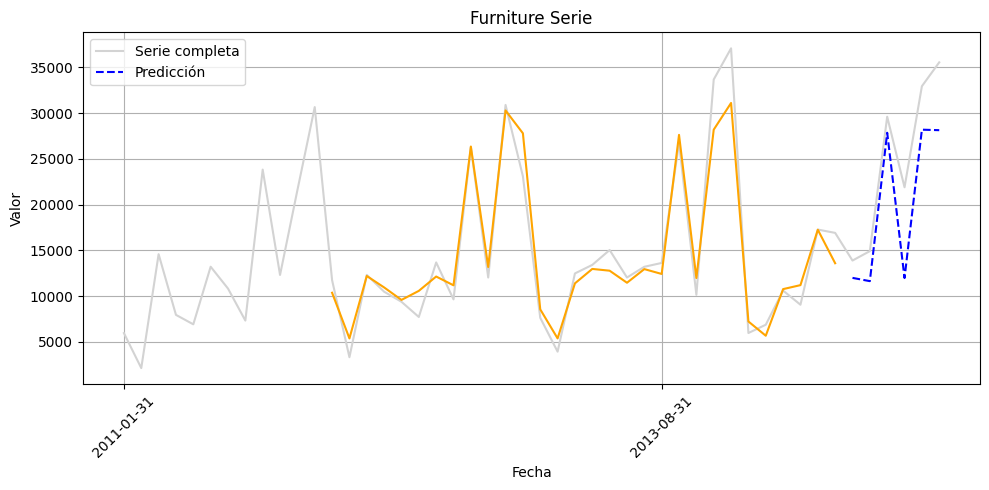

In [371]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df['Furniture'], label='Serie completa', color='lightgray')
ax.plot(furniture_test.index, furniture_test['Predict'], label='Predicción', color='blue', linestyle='--')
ax.plot(sales_furniture.index,best_furniture.predict(sales_furniture.drop(columns='y')), color='orange')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)
ax.set_title('Furniture Serie')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

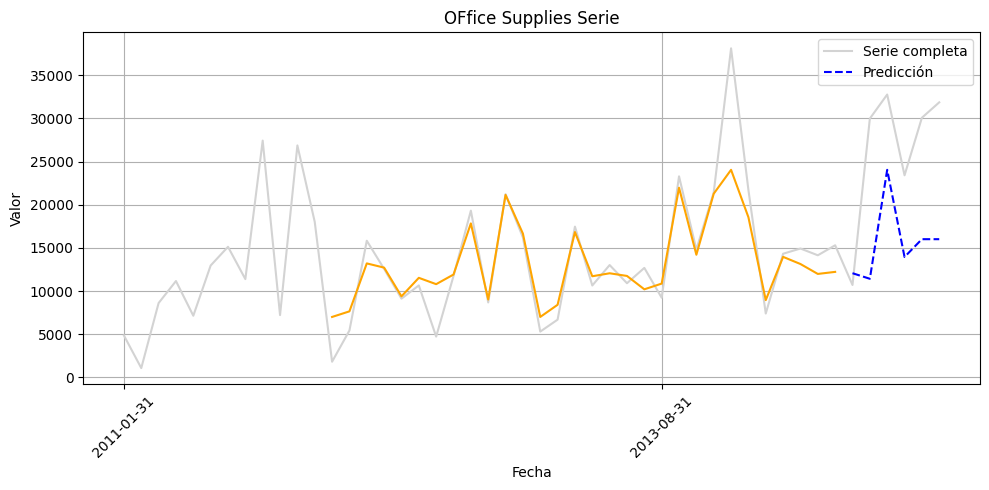

In [372]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df['Office Supplies'], label='Serie completa', color='lightgray')
ax.plot(office_test.index, office_test['Predict'], label='Predicción', color='blue', linestyle='--')
ax.plot(sales_office.index,best_office.predict(sales_office.drop(columns='y')), color='orange')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)
ax.set_title('OFfice Supplies Serie')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

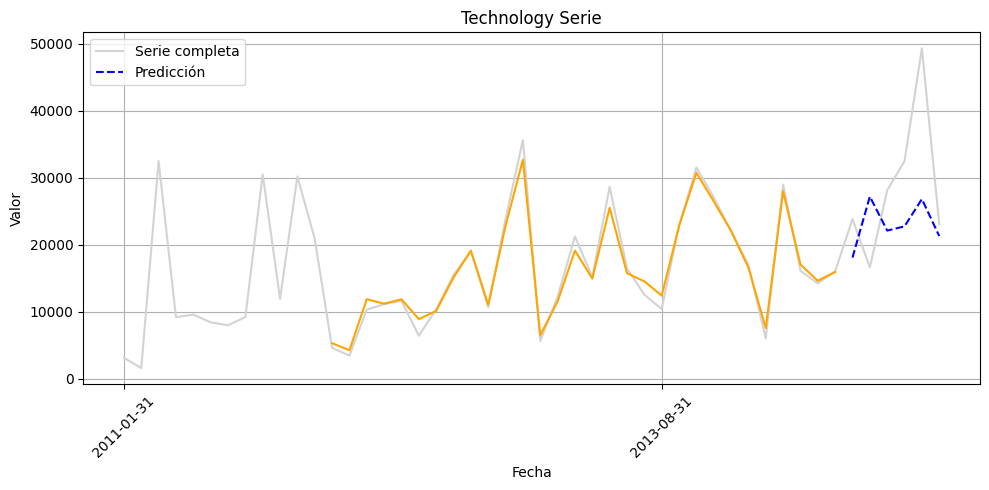

In [373]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(df['Technology'], label='Serie completa', color='lightgray')
ax.plot(tech_test.index, tech_test['Predict'], label='Predicción', color='blue', linestyle='--')
ax.plot(sales_tech.index,best_tech.predict(sales_tech.drop(columns='y')), color='orange')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.xticks(rotation=45)
ax.set_title('Technology Serie')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()